In [1]:
import cirq
from cirq.contrib.svg import SVGCircuit
import time
import qsimcirq
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
def create_circ(x, theta):
    """
    Create circuit which includes three parts:
     - feature map
     - single qubit rotations
     - CNOT layer
    """
    circ = cirq.Circuit()
    theta = theta.reshape(n_qubits,3,n_layers)
    
    # feature map
    f_map = [cirq.rx(np.arcsin(x)).on(q) for q in qubits]
    circ += f_map

    # parametrized layer
    layers = theta.shape[-1]
    for l in range(layers):
        circ += [cirq.ry(theta[i,0,l]).on(q) for i,q in enumerate(qubits)]
        circ += [cirq.rz(theta[i,1,l]).on(q) for i,q in enumerate(qubits)]
        circ += [cirq.ry(theta[i,2,l]).on(q) for i,q in enumerate(qubits)]
        circ += [cirq.CNOT(q0,q1) for q0,q1 in zip(qubits,qubits[1:])]
    
    return circ

In [3]:
def get_expval(x, theta):
    """
    Get expectation value from current state vector
    """
    c = create_circ(x,theta)

    sim = cirq.sim.Simulator()
    #sim = qsimcirq.QSimSimulator()
    res = sim.simulate(c)

    q_measured = qubits[0]
    obs = cirq.Z(q_measured)
    final_state_vector = res.final_state_vector
    phi = obs.expectation_from_state_vector(final_state_vector, {q_measured :0}).real

    return phi

In [25]:
def calculate_loss(theta):
    """
    Calculate loss comparing circuit output to target function
    """
    loss = 0
    theta = theta.reshape(n_qubits,3,n_layers)

    xs = x_train
    ys = y_train

    for i in range(len(xs)):
        phi = get_expval(xs[i], theta)
        y = ys[i]
        loss += (phi-y)**2
    
    return loss

In [26]:
train_pts = 15
x_train = np.linspace(-1,1,train_pts)
y_train = x_train**2

n_qubits = 2
n_layers = 2

In [27]:
qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
theta = np.random.uniform(-np.pi, np.pi, n_qubits*3*n_layers)

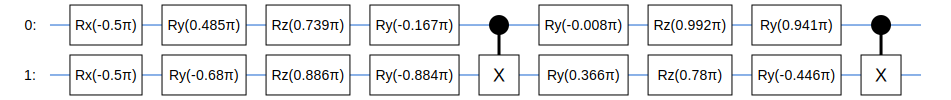

In [28]:
c = create_circ(x_train[0], theta)
SVGCircuit(c)

In [29]:
start_time = time.time()
fit = minimize(calculate_loss, x0=theta, method="Nelder-Mead", options={'maxiter':400, 'disp':True}, tol=1e-2)
print(f'convergence time: {time.time() - start_time}')

Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 260
         Function evaluations: 381
convergence time: 27.724178552627563


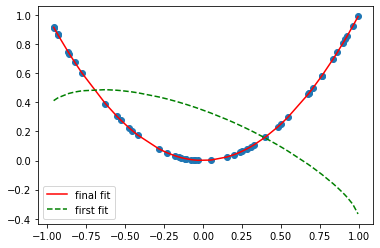

In [32]:
x_fit = np.sort(np.random.uniform(-1, 1, 50))
f_x = x_fit**2

q_fit = np.array([get_expval(x, fit.x) for x in x_fit])
q_first = np.array([get_expval(x, theta) for x in x_fit])

plt.scatter(x_fit,f_x)
plt.plot(x_fit, q_fit, 'r', label='final fit')
plt.plot(x_fit, q_first, 'g--', label='first fit')

plt.legend()
plt.show()